# SynthDet Evaluation

This notebook is for the model prediction visualization. You can load your model and visualize predicted bounding boxes for the GroceriesReal validation dataset. This notebook would show you the performance metrics (mAP, mAP@IOU50, mAR@100) for your model based on GroceriesReal test dataset. Also, this notebook can analyze the easy and hard cases from the point of view of the model. This would provide a better understanding about how to minimize sim2real gaps or improve model performance.<br>
You can use this notebook by the following steps:
- Specify the model path. Then, the notebook would load the checkpoints into a `FasterRCNN` estimator. The `FasterRCNN` can provide model predictions.
- Can either specify or randomly select some cases for the visualization.
- This notebook would analyze high precision, high recall, low precision, low recall cases for the loaded model.

In [1]:
# import pathlib
# import warnings

# from PIL import ImageColor
# from torchvision import transforms
# import numpy as np
# import pandas as pd
# import plotly.express as px
# import torch

# from datasetinsights.datasets import Dataset
# from datasetinsights.evaluation_metrics.confusion_matrix import prediction_records, precision_recall
# from datasetinsights.io import EstimatorCheckpoint, KubeflowPipelineWriter
# from datasetinsights.stats import grid_plot, plot_bboxes, histogram_plot

# delete this later
%load_ext autoreload
%autoreload 2

## Settings
Specify your settings down below

In [1]:
# local data path to save downloaded dataset:
# Why do we need this setting?

# switch to this default path to allow user running inside docker container
# data_root = "/data"
data_root = "/Users/bowen.li/data/"

Specify a pre-trained model that can be used to calculate model performance as well as prediction visualization. You can use one of the model that we pre-trained or use the model that you have trained. 

In [2]:
# 1. Real-trained estimator on 760 images
# estimator_url = "https://storage.googleapis.com/datasetinsights/models/Real-World/FasterRCNN.estimator"

# 2. Synth-trained estimator on 400K SynthDet dataset
# estimator_url = "https://storage.googleapis.com/datasetinsights/models/Synthetic/FasterRCNN.estimator"

# 3. Fine-tuned estimator (pre-trained on 400K Synthetic data and fine-tuned on 76 images)
# estimator_url = "https://storage.googleapis.com/datasetinsights/models/Synthetic-And-Real-World-76-images/FasterRCNN.estimator"

# 4. Fine-tuned estimator (pre-trained on 400K Synthetic data and fine-tuned on 380 images)
# estimator_url = "https://storage.googleapis.com/datasetinsights/models/Synthetic-And-Real-World-380-images/FasterRCNN.estimator"

# 5. Fine-tuned estimator (pre-trained on 400K Synthetic data and fine-tuned on 760 images)
# This is the estimator that provide the best result.
estimator_url = "https://storage.googleapis.com/datasetinsights/models/Synthetic-And-Real-World-760-images/FasterRCNN.estimator"

# How to download the model that they have stored on GCS

## Download GroceriesReal Dataset
Download GrocereisReal data. You only need to download the data once.

In [ ]:
# You only need to download the data once.
# change this variable once we have public groceries real dataset name
import os
from datasetinsights.io import create_downloader

data_path = os.path.join(data_root, "groceries", "v3")

def download_dataset():
    groceries_real_source_uri = "https://storage.googleapis.com/datasetinsights/data/groceries/v3.zip"
    downloader = create_downloader(source_uri=groceries_real_source_uri)
    downloader.download(source_uri=groceries_real_source_uri, output=data_path, include_binary=True)

# uncomment this
download_dataset()

## Load Model

In [6]:
import tempfile
from yacs.config import CfgNode as CN
from datasetinsights.estimators import create_estimator

def estimator_config():
    config_yaml = """
        estimator: FasterRCNN
        backbone: resnet50
        num_classes: 64
        task: object_detection
        test:
          batch_size: 8
          dataset:
            name: GroceriesReal
            args:
              version: v3
              split: test
        metrics:
          mAP:
            name: MeanAveragePrecisionAverageOverIOU
          mAPIOU50:
            name: MeanAveragePrecisionIOU50
          mAR:
            name: MeanAverageRecallAverageOverIOU
        pretrained: False
        pretrained_backbone: True
        synchronize_metrics: True
    """
    config = CN.load_cfg(config_yaml)
    
    return config

def load_estimator(checkpoint_file):  
    config = estimator_config()

    estimator = create_estimator(
        name=config.estimator,
        config=config,
        checkpoint_dir = tempfile.TemporaryDirectory().name,
        checkpoint_file=checkpoint_file,
        kfp_metrics_dir = tempfile.TemporaryDirectory().name,
    )

    return estimator

estimator = load_estimator(estimator_url)

## Model performance metrics
This section would show you the model performance on GroceriesReal test dataset. You would see:

We report three evaluation metrics that's commonly used for object detection task
- [mAP](https://datasetinsights.readthedocs.io/en/latest/datasetinsights.evaluation_metrics.html#datasetinsights.evaluation_metrics.average_precision_2d.MeanAveragePrecisionAverageOverIOU): Average Precision average over all labels and IOU thresholds \[0.5:0.95:0.05\]
- [mAPIOU50](https://datasetinsights.readthedocs.io/en/latest/datasetinsights.evaluation_metrics.html#datasetinsights.evaluation_metrics.average_precision_2d.MeanAveragePrecisionIOU50): Mean Average Precision at IOU=50%.
- [mAR](https://datasetinsights.readthedocs.io/en/latest/datasetinsights.evaluation_metrics.html#datasetinsights.evaluation_metrics.average_recall_2d.MeanAverageRecallAverageOverIOU): Average Recall average over all labels and IOU thresholds \[0.5:0.95:0.05\]

In [8]:
# This step will take a while as it will go through the whole test dataset and make predictions.
# It will be rougly 3-5 min on GPU...
from datasetinsights.datasets import Dataset
# This should be removed.
data_path = os.path.join(data_root, "groceries", "v3")
estimator.model.eval()
estimator.evaluate(data_path)

In [9]:
import pandas as pd

metrics = estimator.metrics
df = pd.DataFrame({
    "metric_name": ["mAP", "mAPIOU50", "mAR"],
    "metric_value": [
        metrics["mAP"].compute(), 
        metrics["mAPIOU50"].compute(), 
        metrics["mAR"].compute()
    ]
})
df

,metric_name,metric_value
0,mAP,0.703276
1,mAPIOU50,0.914774
2,mAR,0.752249


## Model Prediction Visualization

Use the loaded model to predict on GroceriesReal Validation Dataset. We highlight predicted bounding boxes into 2 colors:
- <font color='green'>Green boxes</font>: it's a correct predicted label and overlap the true box enough (overlap >= 0.5). <br>
- <font color='red'>Red boxes</font>: it's a wrong prediction.<br>

In [28]:
from datasetinsights.estimators import FasterRCNN
test_dataset = Dataset.create(
    "GroceriesReal",
    data_path=data_path,
    split="test",
    transforms=FasterRCNN.get_transform(),
)

In [81]:
import os as _os
import os.path as _path
import numpy as np
import cv2 as _cv2
from PIL import ImageFont
import numpy as _np
from hashlib import md5 as _md5


_COLOR_NAME_TO_RGB = dict(
    navy=((0, 38, 63), (119, 193, 250)),
    blue=((0, 120, 210), (173, 220, 252)),
    aqua=((115, 221, 252), (0, 76, 100)),
    teal=((15, 205, 202), (0, 0, 0)),
    olive=((52, 153, 114), (25, 58, 45)),
    green=((0, 204, 84), (15, 64, 31)),
    lime=((1, 255, 127), (0, 102, 53)),
    yellow=((255, 216, 70), (103, 87, 28)),
    orange=((255, 125, 57), (104, 48, 19)),
    red=((255, 47, 65), (131, 0, 17)),
    maroon=((135, 13, 75), (239, 117, 173)),
    fuchsia=((246, 0, 184), (103, 0, 78)),
    purple=((179, 17, 193), (241, 167, 244)),
    gray=((168, 168, 168), (0, 0, 0)),
    silver=((220, 220, 220), (0, 0, 0)),
)

_COLOR_NAMES = list(_COLOR_NAME_TO_RGB)

_DEFAULT_COLOR_NAME = "green"

from datasetinsights.stats.visualization.plots import CUR_DIR

def _rgb_to_bgr(color):
    return list(reversed(color))

def _color_image(image, font_color, background_color):
    return background_color + (font_color - background_color) * image / 255

def _get_label_image(text, font_color_tuple_bgr, background_color_tuple_bgr, font_size=100):
    _FONT_PATH = os.path.join(CUR_DIR, "font", "arial.ttf")
    _FONT = ImageFont.truetype(_FONT_PATH, font_size)
    text_image = _FONT.getmask(text)
    shape = list(reversed(text_image.size))
    bw_image = _np.array(text_image).reshape(shape)

    image = [
        _color_image(bw_image, font_color, background_color)[None, ...]
        for font_color, background_color in zip(
            font_color_tuple_bgr, background_color_tuple_bgr
        )
    ]

    return _np.concatenate(image).transpose(1, 2, 0)

def add(image, left, top, right, bottom, label=None, color=None, font_size=100, box_line_width=15):
    try:
        left, top, right, bottom = int(left), int(top), int(right), int(bottom)
    except ValueError:
        raise TypeError("'left', 'top', 'right' & 'bottom' must be a number")
    
    if label and not color:
        hex_digest = _md5(label.encode()).hexdigest()
        color_index = int(hex_digest, 16) % len(_COLOR_NAME_TO_RGB)
        color = _COLOR_NAMES[color_index]

    colors = [list(item) for item in _COLOR_NAME_TO_RGB[color]]
    color, color_text = colors

    _cv2.rectangle(image, (left, top), (right, bottom), color, box_line_width)

    if label:
        _, image_width, _ = image.shape

        label_image = _get_label_image(label, color_text, color, font_size)
        label_height, label_width, _ = label_image.shape

        rectangle_height, rectangle_width = 1 + label_height, 1 + label_width

        rectangle_bottom = top
        rectangle_left = max(0, min(left - 1, image_width - rectangle_width))

        rectangle_top = rectangle_bottom - rectangle_height
        rectangle_right = rectangle_left + rectangle_width

        label_top = rectangle_top + 1

        if rectangle_top < 0:
            rectangle_top = top
            rectangle_bottom = rectangle_top + label_height + 1

            label_top = rectangle_top

        label_left = rectangle_left + 1
        label_bottom = label_top + label_height
        label_right = label_left + label_width

        rec_left_top = (rectangle_left, rectangle_top)
        rec_right_bottom = (rectangle_right, rectangle_bottom)

        _cv2.rectangle(image, rec_left_top, rec_right_bottom, color, -1)

        image[label_top:label_bottom, label_left:label_right, :] = label_image

In [82]:
def process_label(bbox, label_mappings=None):
    if label_mappings:
        label = label_mappings[bbox.label]
    if bbox.score != 1.0:
        return f"{label}: {bbox.score * 100: .2f}%"
    else:
        return label

def match_boxes(pred_bboxes, gt_bboxes):
    """ Provide a list of colors for pred annotations
    """
    from datasetinsights.evaluation_metrics.confusion_matrix import prediction_records
    records = prediction_records(gt_bboxes, pred_bboxes)
    # change to records.match_result
    match_result = records
    
    def get_color(match):
        if match:
            return "green"
        else:
            return "red"
    
    colors = [get_color(match)  for _, match in match_result]
    return colors

from PIL import Image
def plot_bboxes(
    image, bboxes, label_mappings=None, colors=None
):
    """ Plot an image with bounding boxes.

    Args:
        image (PIL Image): a PIL image.
        boxes (list): a list of BBox2D objects.
        colors (list): a color list for boxes. Defaults to None.
        If colors = None, it will randomly assign PIL.COLORS for each box.
        box_line_width (int): line width of the bounding boxes. Defaults to 15.
        font_size (int): font size for each label. Defaults to 100.

    Returns:
        a PIL image with bounding boxes drawn.
    """
    np_image = np.array(image)
    for i, box in enumerate(bboxes):
        left, top = (box.x, box.y)
        right, bottom = (box.x + box.w, box.y + box.h)
        label = process_label(box, label_mappings)
        color = colors[i] if colors else None
    
        add(np_image, left, top, right, bottom, label, color)

    return Image.fromarray(np_image)

from torchvision import transforms
from datasetinsights.estimators import convert_bboxes2canonical
from datasetinsights.stats import grid_plot

def visualize_predictions(estimator, dataset, index):
    # keep in notebook
    pil_image, gt_bboxes = dataset[index]
    gt_bboxes = convert_bboxes2canonical([gt_bboxes])[0]
    image = transforms.ToPILImage()(pil_image).convert("RGB")
    pred_bboxes = estimator.predict(pil_image, box_score_thresh=0.5)
    colors = match_boxes(pred_bboxes, gt_bboxes)
    gt_plot = plot_bboxes(image, gt_bboxes, dataset.label_mappings)
    pred_plot = plot_bboxes(image, pred_bboxes, dataset.label_mappings, colors)
    
    titles = [
        f"ground truth bounding boxes for Image {index + 1}",
        f"model prediction for Image {index + 1}",
    ]
    grid_plot([[gt_plot, pred_plot]], figsize=(7, 10), img_type="rgb", titles=titles)

[(0.9998140931129456, True), (0.9997273087501526, True), (0.9992281198501587, True), (0.9985321760177612, True), (0.9982953667640686, True), (0.9961473941802979, True)]


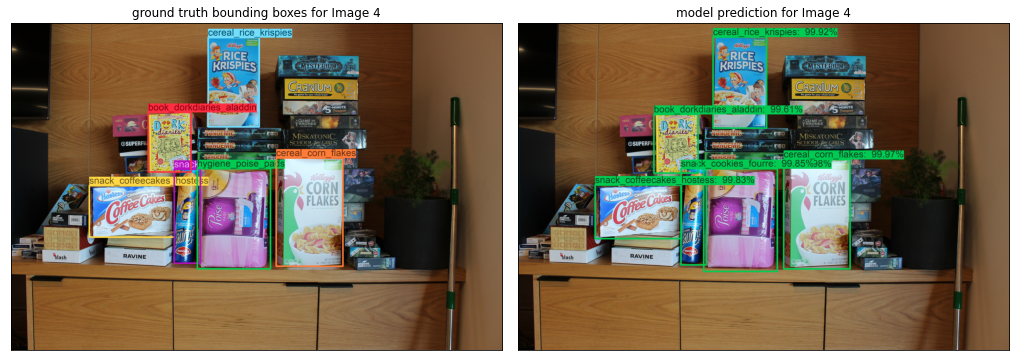

In [80]:
visualize_predictions(estimator, test_dataset, 3)

### Predictions for some user-selected or randomly-selected cases

You can specify some cases or randomly select K cases. For each image, there are two plots:
- The left one is the ground truth image. <br>
- The right one is the model prediction.<br>

In [15]:
# specify image_indicies if you want to visualize a particular set of images
# image_indicies = [0, 1, 2]
image_indicies = np.random.randint(0, len(val_dataset) - 1, size=K)

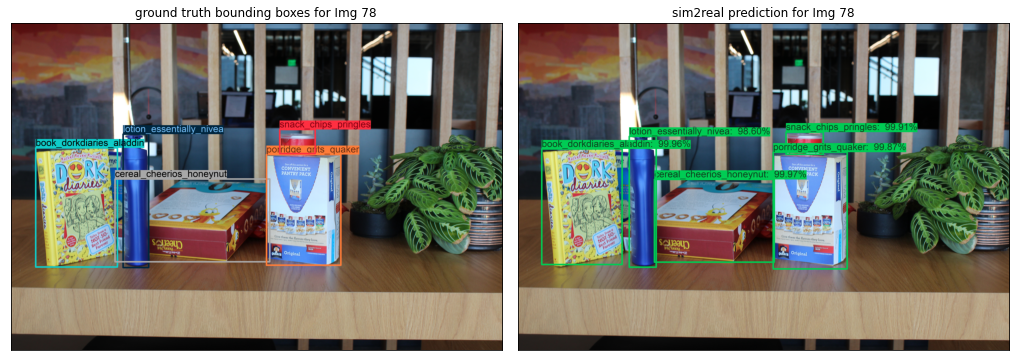

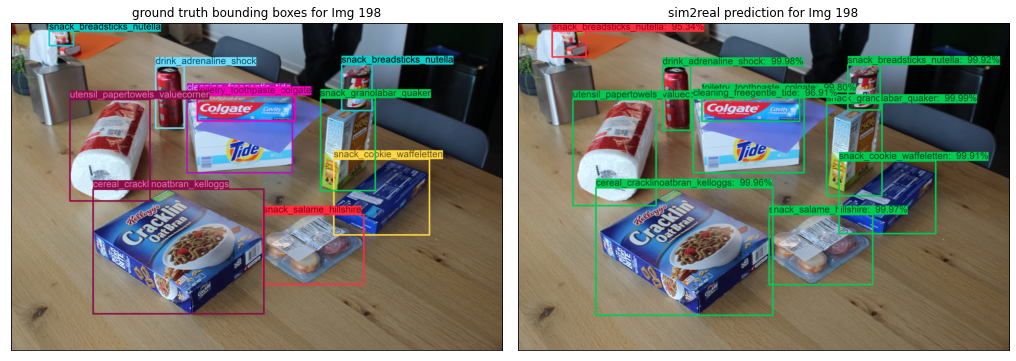

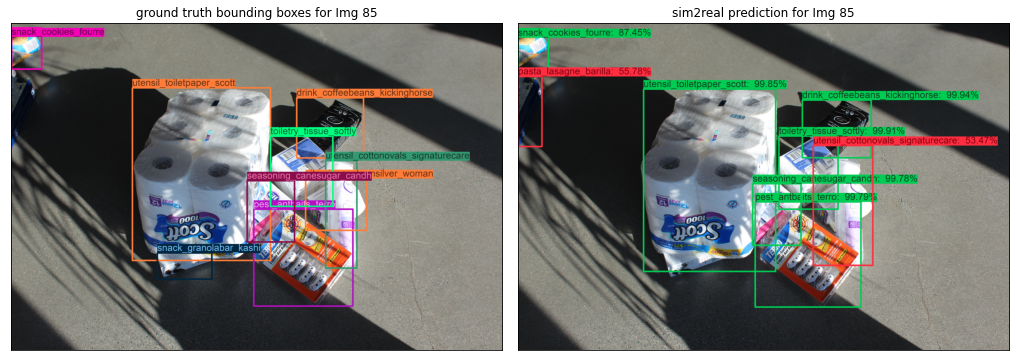

In [19]:
visualize_predictions(image_indicies)